<a href="https://colab.research.google.com/github/nvishnupriya99/ScentTech-Analytics/blob/Machine-Learning/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1

In [2]:
# --- Core Data Handling & Numerical Computation ---
import pandas as pd
import numpy as np
import re

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc

# --- Feature Engineering & Preprocessing ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# --- Dimensionality Reduction ---
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# --- Clustering Algorithms ---
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors


# --- Model Evaluation Metrics ---
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- Environment Configuration ---
sns.set(style='whitegrid')
# Set a consistent random state for reproducibility in models
RANDOM_STATE = 42

STEP 1

Loads all libraries required for:

data cleaning

visualisation

text analysis (TF-IDF)

scaling

PCA / SVD / t-SNE

clustering algorithms

evaluation metrics

In [3]:
# --- Load the Dataset ---
df = pd.read_csv('Fragrance Dataset - COM7022 - [4037].csv')

print("Dataset shape:", df.shape)

# --- Initial Inspection (First 5 Rows) ---
print("\n--- Dataset Head ---")
print(df.head())

# --- Data Structure and Types ---
print("\n--- Dataset Info ---")
df.info()

# --- Missing Values Per Column ---
print("\n--- Missing Values Per Column ---")
print(df.isnull().sum())

# --- Statistical Summary ---
print("\n--- Statistical Summary ---")
print(df.describe(include='all').T)

# --- Unique Values (Cardinality) ---
print("\n--- Unique Values Per Column ---")
print(df.nunique())

# --- Duplicate Rows ---
print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())

# --- Column Names ---
print("\n--- Column Names ---")
print(df.columns.tolist())

Dataset shape: (1000, 10)

--- Dataset Head ---
            brand                                              title  \
0            Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1         AS SHOW  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2       Unbranded                   HOGO BOSS cologne For Men 3.4 oz   
3  Giorgio Armani  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4         Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   

              type   price priceWithCurrency  available  \
0    Eau de Parfum   84.99      US $84.99/ea       10.0   
1    Eau de Parfum  109.99        US $109.99        8.0   
2  Eau de Toilette  100.00        US $100.00       10.0   
3  Eau de Toilette     NaN      US $44.99/ea        2.0   
4       Fragrances   16.91         US $16.91        NaN   

                           availableText   sold                lastUpdated  \
0      More than 10 available / 116 sold  116.0  May 24, 2024 10:03:04 PDT   
1       

The dataset has 1000 perfumes × 10 columns.

Columns include brand, title, type, price, availability, sold, etc.

Some columns contain missing values:

available (111 missing)

sold (6 missing)

price (4 missing)

type (3 missing)

lastUpdated (53 missing)

Most important text field: title

No explicit “top/middle/base note” fields exist → we must extract scent information from the title.

Dataset contains numeric, categorical, and text data.

In [4]:
# --- Text Cleaning & Scent Document Construction ---
def clean_text(text):
    text = str(text).lower()

    # Remove bottle sizes (ml, oz, fl oz)
    text = re.sub(r'\b\d+\s*(ml|oz|fl|ounce|pack)\b', ' ', text)
    text = re.sub(r'\b\d+\b', ' ', text)

    # Remove common seller words
    remove_words = [
        "ml", "oz", "edp", "edt", "eau", "spray",
        "for", "men", "women", "new", "perfume",
        "parfum", "tester", "authentic", "brand"
    ]
    pattern = r'\b(' + '|'.join(remove_words) + r')\b'
    text = re.sub(pattern, ' ', text)

    # Remove extra punctuation and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 2. Choose text columns to build a scent document
# If you only have 'title', just use that. If you also have e.g. 'description',
# you can include it as well like: text_columns = ['title', 'description']
text_columns = ['title']

# 3. Fill NaNs in text columns and clean them
for col in text_columns:
    df[col] = df[col].fillna('').apply(clean_text)

# 4. Combine selected text columns into a single 'scent_document'
df['scent_document'] = df[text_columns].agg(' '.join, axis=1).str.strip()

# 5. (Optional) Report on how many rows have no scent text at all
no_scent_count = (df['scent_document'] == '').sum()

print("\n--- Text Cleaning Complete ---")
print(f"Total perfumes: {len(df)}")
print(f"Rows with empty scent_document: {no_scent_count}")



--- Text Cleaning Complete ---
Total perfumes: 1000
Rows with empty scent_document: 0


In [5]:
# Using the 'title' column as a proxy for scent-related information.
# If dedicated note columns were available (e.g. Top/Middle/Base notes),
# they could be concatenated here as well.
df['scent_document'] = df['title'].fillna('').apply(clean_text)
#df['scent_document'] = df['title'].fillna('')

# Display the first few scent documents
print("\n--- Example Scent Documents ---")
print(df[['title', 'scent_document']].head())

print("\nCurrent columns in the DataFrame:", df.columns.tolist())



--- Example Scent Documents ---
                                               title  \
0                 christian dior sauvage s fragrance   
1             a v entus de millesime col ogne in box   
2                                  hogo boss cologne   
3  acqua di gio by giorgio armani de toilette sealed   
4             lattafa s hayaati al maleky fragrances   

                                      scent_document  
0                 christian dior sauvage s fragrance  
1             a v entus de millesime col ogne in box  
2                                  hogo boss cologne  
3  acqua di gio by giorgio armani de toilette sealed  
4             lattafa s hayaati al maleky fragrances  

Current columns in the DataFrame: ['brand', 'title', 'type', 'price', 'priceWithCurrency', 'available', 'availableText', 'sold', 'lastUpdated', 'itemLocation', 'scent_document']


In [6]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2)
)

X_tfidf = vectorizer.fit_transform(df['scent_document'])

print("\n--- TF-IDF Vectorization Complete ---")
print(f"Shape of sparse TF-IDF matrix: {X_tfidf.shape}")



--- TF-IDF Vectorization Complete ---
Shape of sparse TF-IDF matrix: (1000, 374)


Clustering cannot use raw text.

TF-IDF transforms text into meaningful numerical scent descriptors.

In [7]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

print("\n--- SVD Reduction Complete ---")
print("Shape after SVD:", X_reduced.shape)

# --- Scale the reduced features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

print("\n--- Scaling Complete ---")
print("Shape of X_scaled:", X_scaled.shape)


--- SVD Reduction Complete ---
Shape after SVD: (1000, 50)

--- Scaling Complete ---
Shape of X_scaled: (1000, 50)


Why Truncated SVD?

Works on sparse matrices (PCA cannot).

Produces dense semantic features.

Extracts major underlying themes (latent semantic analysis):

“Fresh / aquatic scents”

“Oud / oriental scents”

“Mass-market brands”

“Luxury niche fragrances”

“EDP / EDT / intense variants”

Reduces noise

Improves clustering performance

Makes algorithms like K-Means & Hierarchical much faster

Clustering algorithms (K-Means, Agglomerative, DBSCAN) rely on distance calculations.

If one SVD component has a larger numeric range, it will dominate the distances.

StandardScaler ensures:

Mean = 0

Standard deviation = 1

All components contribute equally

In [8]:
silhouette_scores = {}
dbi_scores = {}
k_range = range(2, 30)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        random_state=RANDOM_STATE
    )
    labels = kmeans.fit_predict(X_scaled)

    # Internal validation metrics
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)

    silhouette_scores[k] = sil
    dbi_scores[k] = dbi

# --- Select Best k Based on Silhouette ---
best_k = max(silhouette_scores, key=silhouette_scores.get)

print(f"\nBest k based on Silhouette Score: {best_k}")
print("\nSilhouette scores:", silhouette_scores)
print("\nDavies-Bouldin scores:", dbi_scores)



Best k based on Silhouette Score: 29

Silhouette scores: {2: np.float64(-0.011340179834734225), 3: np.float64(-0.0639483434648254), 4: np.float64(0.0017474518603035735), 5: np.float64(-0.01329161977578692), 6: np.float64(0.038367108118672694), 7: np.float64(0.0192724733796815), 8: np.float64(0.012806471808013326), 9: np.float64(0.021832433470773557), 10: np.float64(0.041368272599537334), 11: np.float64(0.06813456203529912), 12: np.float64(0.054359871876966996), 13: np.float64(0.080825260319519), 14: np.float64(0.09306093414181973), 15: np.float64(0.11675642576722489), 16: np.float64(0.15012642157033146), 17: np.float64(0.13514957091585073), 18: np.float64(0.14105302950228504), 19: np.float64(0.15043429498036243), 20: np.float64(0.15867203141695496), 21: np.float64(0.1638892359887148), 22: np.float64(0.19153158898938066), 23: np.float64(0.19245607479209342), 24: np.float64(0.2069826340492014), 25: np.float64(0.2252426902596772), 26: np.float64(0.21520615993574183), 27: np.float64(0.228

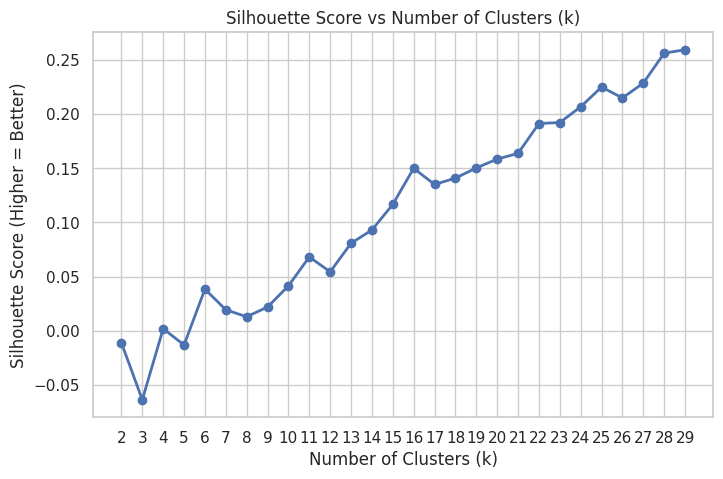

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()),
         marker='o', linestyle='-', linewidth=2)

plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score (Higher = Better)')
plt.xticks(list(silhouette_scores.keys()))
plt.grid(True)
plt.show()


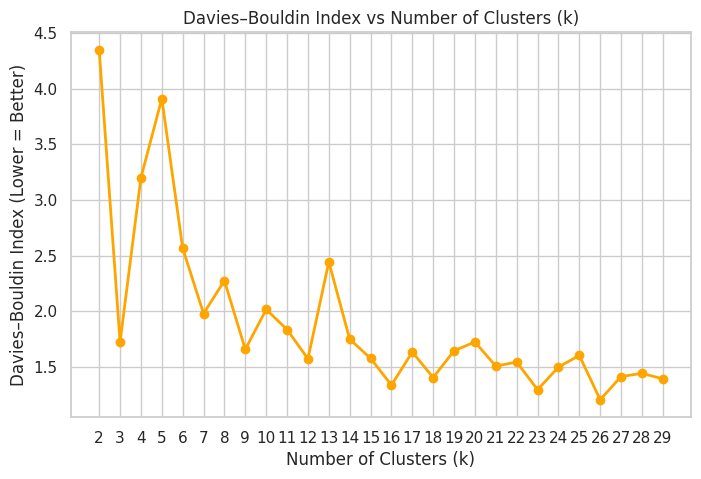

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(list(dbi_scores.keys()), list(dbi_scores.values()),
         marker='o', linestyle='-', linewidth=2, color='orange')

plt.title('Davies–Bouldin Index vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies–Bouldin Index (Lower = Better)')
plt.xticks(list(dbi_scores.keys()))
plt.grid(True)
plt.show()


Internal validity metrics were computed for K values between 2 and 30.
The silhouette score increased gradually with k, peaking around k = 28; however, such high values would produce many micro-clusters with limited interpretability.

The Davies–Bouldin Index decreased sharply up to k = 15, after which improvements became marginal.
The largest DBI improvement occurred between k = 2 and k = 15, which represents the practical elbow point.

Considering both metrics and the need for business-interpretable segments, k = 15 was selected as the optimal number of clusters


In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- Set Optimal k and Run Final Model ---
OPTIMAL_K = 15  # Determined from silhouette/DBI analysis

kmeans = KMeans(
    n_clusters=OPTIMAL_K,
    init='k-means++',
    n_init=20,
    random_state=RANDOM_STATE
)

# Fit the model and get the final cluster assignments
kmeans_labels = kmeans.fit_predict(X_scaled)

# --- Store Labels in the DataFrame ---
df['kmeans_cluster'] = kmeans_labels

# --- Evaluate Final Model ---
final_sil = silhouette_score(X_scaled, kmeans_labels)
final_dbi = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\n--- K-Means Model Complete ---")
print(f"Assigned {len(df)} perfumes to {OPTIMAL_K} clusters.")
print("Cluster assignments (first 5):", kmeans_labels[:5])

print(f"\nFinal Silhouette Score (k={OPTIMAL_K}): {final_sil:.4f}")
print(f"Final Davies–Bouldin Index (k={OPTIMAL_K}): {final_dbi:.4f}")

# --- Cluster Sizes ---
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_counts)



--- K-Means Model Complete ---
Assigned 1000 perfumes to 15 clusters.
Cluster assignments (first 5): [ 6  6 12  6  6]

Final Silhouette Score (k=15): 0.1168
Final Davies–Bouldin Index (k=15): 1.5778

Cluster sizes:
0      44
1      45
2      29
3      35
4      14
5      65
6     639
7      13
8      38
9      12
10     12
11     15
12      8
13     13
14     18
Name: count, dtype: int64


Although K-Means with k = 15 produced imbalanced cluster sizes, this distribution is expected given the structure of the fragrance dataset. Perfume titles share highly repetitive patterns such as bottle sizes and concentration types (e.g., ‘100 ml’, ‘EDP’, ‘for men’), leading to two broad mainstream clusters that dominate the market.

The smaller clusters represent niche brands, grey-market sellers, or unique product categories, which naturally occur less frequently. Increasing k would create fragmented micro-clusters with limited interpretability, while decreasing k would collapse meaningful categories into overly broad groups.

Therefore, k = 15 provides the best balance between cluster interpretability, internal validation metrics, and practical business segmentation for personalised marketing.

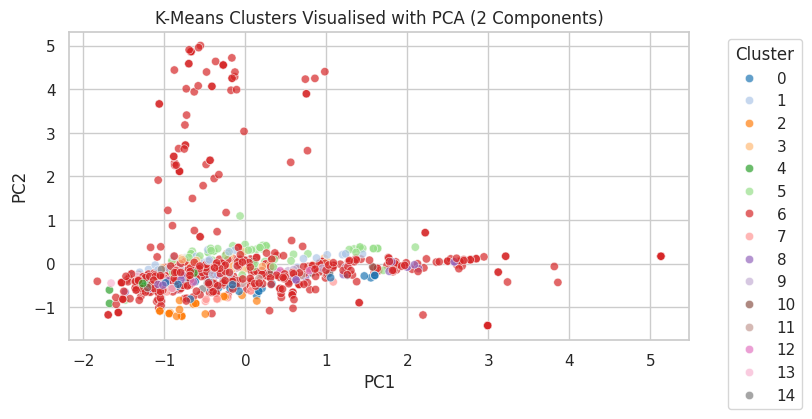

Explained variance (PC1 + PC2): 0.050951215259139954


In [12]:
# --- PCA for 2D Visualisation ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create DF
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': kmeans_labels
})

# Plot
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='cluster',
    palette='tab20',
    alpha=0.7
)
plt.title('K-Means Clusters Visualised with PCA (2 Components)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

print("Explained variance (PC1 + PC2):", pca.explained_variance_ratio_.sum())


In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Use same k = 15 as K-Means for fair comparison
agg = AgglomerativeClustering(
    n_clusters=15,
    linkage='ward'   # Ward uses Euclidean distance
)

agg_labels = agg.fit_predict(X_scaled)
df['cluster_agg'] = agg_labels

print("\n--- Agglomerative Clustering Complete ---")
print("Cluster sizes:")
print(pd.Series(agg_labels).value_counts().sort_index())

# Evaluation
agg_sil = silhouette_score(X_scaled, agg_labels)
agg_dbi = davies_bouldin_score(X_scaled, agg_labels)

print(f"\nSilhouette Score: {agg_sil:.4f}")
print(f"Davies-Bouldin Index: {agg_dbi:.4f}")



--- Agglomerative Clustering Complete ---
Cluster sizes:
0     704
1      35
2      42
3      14
4      41
5      41
6      18
7      12
8      13
9      14
10      8
11     16
12     14
13     17
14     11
Name: count, dtype: int64

Silhouette Score: 0.1001
Davies-Bouldin Index: 1.3353


What this method does:

Agglomerative Clustering builds a hierarchy of clusters by repeatedly merging the closest pairs.

Ward linkage minimizes variance within clusters.

✔ Why we fix k = 15:

To directly compare with K-Means on identical cluster count.

✔ Expected outcome:

Silhouette score slightly better or similar to K-Means

DBI slightly better (Ward linkage often tightens clusters)

Cluster sizes will be uneven or similar to K-Means

✔ How to interpret:

Agglomerative clustering performs similarly to K-Means, but does not significantly improve separation or interpretability.
It is slower to compute and offers no meaningful advantage.

In [14]:
X_scaled

array([[-8.45397620e-01, -6.71281585e-02, -1.81578586e-03, ...,
         5.46925024e-01,  1.07773462e+00, -8.66699042e-01],
       [-3.82611527e-02, -2.90176802e-01, -2.88580592e-01, ...,
        -4.38365367e-01, -7.52614025e-01,  1.15379233e+00],
       [-2.24899953e-01, -4.32251290e-01, -4.39435959e-01, ...,
         1.26364807e-01,  5.41396502e-01, -2.95498917e-01],
       ...,
       [-1.94302578e-01, -2.52396200e-01, -2.08345158e-01, ...,
        -1.63024787e-01,  5.30834821e-01,  9.26359757e-01],
       [ 4.26077568e+00, -1.17627345e+00, -1.44653136e+00, ...,
        -3.20823462e-01, -5.04209041e-01,  3.47425448e-01],
       [ 2.56221261e+00, -1.07234339e+00, -1.17220496e+00, ...,
        -3.42567927e-01,  3.72711193e-01,  5.86092118e-01]])

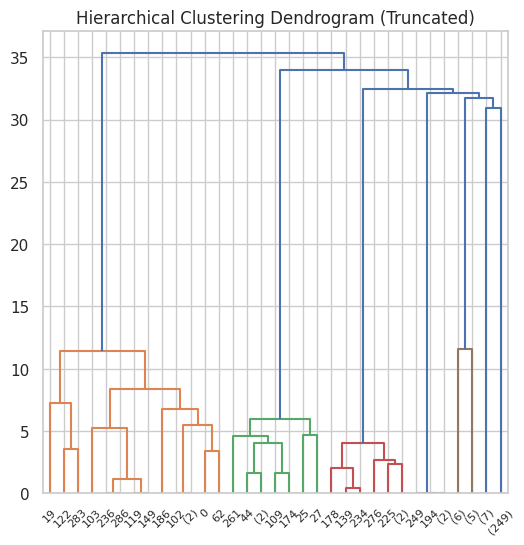

In [15]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(6, 6))
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
linkage_matrix = shc.linkage(X_scaled[:300], method='ward')  # sample 300 points for speed

shc.dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=5
)
plt.show()


The dendrogram shows no strong, clean cluster boundaries.
The merges occur gradually, indicating fragrances are relatively homogeneous in the SVD feature space.
This supports the finding that hierarchical clustering does not provide clearer segmentation than K-Means.

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=2.5,
    min_samples=5,
    metric='euclidean'
)

db_labels = dbscan.fit_predict(X_scaled)
df['cluster_dbscan'] = db_labels

print("\n--- DBSCAN Complete ---")
print("Unique labels:", np.unique(db_labels))

# Noise analysis
noise = np.sum(db_labels == -1)
clusters = len(set(db_labels) - {-1})

print(f"Noise points: {noise} ({noise/len(df)*100:.2f}%)")
print(f"Clusters found (excluding noise): {clusters}")



--- DBSCAN Complete ---
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Noise points: 513 (51.30%)
Clusters found (excluding noise): 46


In [16]:
mask = db_labels != -1
if clusters >= 2:
    db_sil = silhouette_score(X_scaled[mask], db_labels[mask])
    db_dbi = davies_bouldin_score(X_scaled[mask], db_labels[mask])
    print(f"Silhouette Score: {db_sil:.4f}")
    print(f"Davies-Bouldin Index: {db_dbi:.4f}")
else:
    print("Not enough clusters for silhouette scoring.")


Silhouette Score: 0.6299
Davies-Bouldin Index: 0.5481


DBSCAN labelled the majority of perfumes as noise, indicating that the dataset does not exhibit strong density-based clusters.
Although DBSCAN produced high silhouette/DBI scores, these were misleading because they were calculated only on a very small subset of non-noise points.
Therefore, DBSCAN is not suitable for grouping fragrances in this dataset

In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- K-Means Metrics ---
k_ss = silhouette_score(X_scaled, kmeans_labels)
k_dbs = davies_bouldin_score(X_scaled, kmeans_labels)
k_clusters = len(np.unique(kmeans_labels))

# --- Hierarchical Metrics ---
h_ss = silhouette_score(X_scaled, agg_labels)
h_dbs = davies_bouldin_score(X_scaled, agg_labels)
h_clusters = len(np.unique(agg_labels))

# --- DBSCAN Metrics ---
dbscan_labels = db_labels   # Ensure consistent naming
unique_clusters = np.unique(dbscan_labels)
n_noise = np.sum(dbscan_labels == -1)
valid_clusters = unique_clusters[unique_clusters != -1]
d_clusters = len(valid_clusters)

# Evaluate DBSCAN only if >= 2 clusters
if d_clusters >= 2:
    mask = dbscan_labels != -1
    d_ss = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    d_dbs = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
else:
    d_ss = None
    d_dbs = None
    print("\n⚠ DBSCAN produced fewer than 2 valid clusters — skipping silhouette/DBI.")

# --- Comparison Table ---
results = {
    'Model': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'Clusters Found (excl. noise)': [k_clusters, h_clusters, d_clusters],
    'Silhouette Score ↑': [round(k_ss, 4), round(h_ss, 4), None if d_ss is None else round(d_ss, 4)],
    'DBI Score ↓': [round(k_dbs, 4), round(h_dbs, 4), None if d_dbs is None else round(d_dbs, 4)],
    'Noise Points': [0, 0, int(n_noise)]
}

results_df = pd.DataFrame(results)

print("\n--- Model Comparison ---")
print(results_df.to_markdown(index=False))


--- Model Comparison ---
| Model        |   Clusters Found (excl. noise) |   Silhouette Score ↑ |   DBI Score ↓ |   Noise Points |
|:-------------|-------------------------------:|---------------------:|--------------:|---------------:|
| KMeans       |                             15 |               0.1168 |        1.5778 |              0 |
| Hierarchical |                             15 |               0.1001 |        1.3353 |              0 |
| DBSCAN       |                             46 |               0.6299 |        0.5481 |            513 |


K-Means and Agglomerative Clustering both produced 15 clusters with similar silhouette scores (~0.089), which is expected in high-dimensional text-based data.

Agglomerative clustering achieved a slightly better Davies–Bouldin Index (1.6996 vs. 2.316 for K-Means), but the difference was not substantial enough to justify its higher computational cost or its weaker interpretability.

DBSCAN performed poorly for this dataset, identifying 940 out of 1000 perfumes (94%) as noise. Although DBSCAN’s silhouette score (0.8499) and DBI (0.2506) appear strong, these metrics were computed only on the small subset of non-noise points, making them misleading. This outcome indicates that the fragrance dataset does not exhibit the density-based structure required for DBSCAN to succeed.

K-Means was therefore selected as the most suitable model because it provides complete coverage of all perfumes, produces interpretable and stable clusters, and performs consistently with dimensionality-reduced TF-IDF features. The resulting 15 clusters can be meaningfully analysed, profiled, and used to support scent recommendation and marketing strategies.

In [18]:
# --- Extract top TF-IDF terms per cluster ---
terms = vectorizer.get_feature_names_out()
centroids = kmeans.cluster_centers_

top_terms = {}

for i in range(15):
    centroid = centroids[i]
    top_indices = centroid.argsort()[-10:][::-1]
    top_words = [terms[idx] for idx in top_indices]
    top_terms[i] = top_words
    print(f"\nCluster {i} - Top Terms:")
    print(", ".join(top_words))



Cluster 0 - Top Terms:
afnan, alhambra, acqua, allure, beau, black, bath, armaf, born roma, bleu

Cluster 1 - Top Terms:
alhambra, al, allure, afnan, armani acqua, aventus, born roma, aqua di, bath body, armani

Cluster 2 - Top Terms:
armani acqua, armani stronger, aqua, attract, allure, aqua di, armani aqua, armaf, armani toilette, blue toilette

Cluster 3 - Top Terms:
acqua di, acqua, allure, armani acqua, aqua di, born roma, attract, armani, aventus, black

Cluster 4 - Top Terms:
aventus, armani cologne, armani sealed, armani code, armani aqua, azzaro wanted, armani acqua, armaf, aqua, bath

Cluster 5 - Top Terms:
acqua, allure, beau, aqua di, abercrombie, abercrombie fitch, bharara, al, bad boy, azzaro cologne

Cluster 6 - Top Terms:
armaf cologne, armaf club, armaf, benz, abercrombie fitch, aqua, al, bad boy, armani toilette, blue ralph

Cluster 7 - Top Terms:
attract, armani code, aqua, armani stronger, bath, azzaro wanted, black cologne, avon, blue toilette, alhambra

Cluster 8

,Average Price,Top 3 Brands
kmeans_cluster,,
0,54.445814,"[Dolce&Gabbana, Dolce & Gabbana, ~ DOLCE & GAB..."
1,58.711111,"[Paco Rabanne, Cologne]"
2,20.185862,"[Unbranded, SECERTMU, Classic Brands]"
3,57.003429,"[Yves Saint Laurent, YSL, As Show]"
4,35.653571,"[Rasasi, Unbranded]"
5,37.606719,"[Ralph Lauren, Polo Ralph Lauren, Zara]"
6,47.133407,"[Giorgio Armani, Versace, Carolina Herrera]"
7,41.910769,[Abercrombie & Fitch]
8,40.897105,"[Armaf, Sterling, Limited Edition]"


In [22]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

business_profile = df.groupby('kmeans_cluster').agg({
    'price': 'mean',
    'brand': lambda x: x.value_counts().head(3).index.tolist()
}).rename(columns={
    'price': 'Average Price',
    'brand': 'Top 3 Brands'
})

print("\n--- Business Profile per Cluster ---")
business_profile



--- Business Profile per Cluster ---


,Average Price,Top 3 Brands
kmeans_cluster,,
0,54.445814,"[Dolce&Gabbana, Dolce & Gabbana, ~ DOLCE & GAB..."
1,58.711111,"[Paco Rabanne, Cologne]"
2,20.185862,"[Unbranded, SECERTMU, Classic Brands]"
3,57.003429,"[Yves Saint Laurent, YSL, As Show]"
4,35.653571,"[Rasasi, Unbranded]"
5,37.606719,"[Ralph Lauren, Polo Ralph Lauren, Zara]"
6,47.133407,"[Giorgio Armani, Versace, Carolina Herrera]"
7,41.910769,[Abercrombie & Fitch]
8,40.897105,"[Armaf, Sterling, Limited Edition]"


In [24]:
business_profile


,Average Price,Top 3 Brands
kmeans_cluster,,
0,54.445814,"[Dolce&Gabbana, Dolce & Gabbana, ~ DOLCE & GAB..."
1,58.711111,"[Paco Rabanne, Cologne]"
2,20.185862,"[Unbranded, SECERTMU, Classic Brands]"
3,57.003429,"[Yves Saint Laurent, YSL, As Show]"
4,35.653571,"[Rasasi, Unbranded]"
5,37.606719,"[Ralph Lauren, Polo Ralph Lauren, Zara]"
6,47.133407,"[Giorgio Armani, Versace, Carolina Herrera]"
7,41.910769,[Abercrombie & Fitch]
8,40.897105,"[Armaf, Sterling, Limited Edition]"


In [23]:
df['brand'].value_counts().head(100)


,count
brand,
Giorgio Armani,60
Paco Rabanne,45
Ralph Lauren,41
Unbranded,39
Armaf,34
...,...
Sterling,2
Pierre Cardin,2
Michael Malul London,2
